7.22 Dota version

what im trying to do so far is to websrap dota page theory about hero counters. 

In theory, each heroes will have counter heroes and items

                            # Skip this part, already saved and will load the result

In [ ]:
def get_heroes_matchup_info(hero_name, heroes_mentioned):
    
    # Part 1: clean up the information collected from the webite  
    # filter non type element in the list
    heroes_mentioned = list(filter(None, heroes_mentioned)) 

    # cut short the list to only relevant heroes
    heroes_mentioned_clean = heroes_mentioned[heroes_mentioned.index('/index.php?title=' + hero_name + \
                                                                     '/Counters&action=edit&section=1'): 
                                              heroes_mentioned.index('/Dota_2_Wiki:About') -1]

    # remove '/' i the list
    heroes_mentioned_clean = [heroes_mentioned[i].strip('/') for i in 
                              range(len(heroes_mentioned))]    

    # remove duplicates in the list    
    heroes_mentioned_clean = unique(heroes_mentioned_clean)

    # remove skills and items (can think more about this later)
    heroes_mentioned_clean1 = []

    for i in range(len(heroes_mentioned_clean)):
        if '#' not in heroes_mentioned_clean[i]:
            heroes_mentioned_clean1.append(heroes_mentioned_clean[i])

    # filter only heroes        
    heroes_mentioned_clean2 = [heroes_mentioned_clean1[i] for i in 
                               range(len(heroes_mentioned_clean1)) if 
                               heroes_mentioned_clean1[i] in heroes_name_list]

    # Part 2: populate the hero's matchup info   
    # In the page, heroes that counters the hero well is in red  
    heroes_countered1 = []

    productDivs = soup.findAll('div', attrs={'style': 'margin-bottom:5px; box-shadow:0px 0px 2px 4px red;'})
    for div in productDivs:
        heroes_countered1.append(div.find('a')['href'].strip('/'))

    # In the page, heroes that the hero counters well is in green       
    heroes_counter1 = []

    productDivs_chartreuse = soup.findAll('div', attrs={'style': 'margin-bottom:5px; box-shadow:0px 0px 2px 4px chartreuse;'})
    productDivs_green = soup.findAll('div', attrs={'style': 'margin-bottom:5px; box-shadow:0px 0px 2px 4px green;'})
    productDivs = productDivs_chartreuse + productDivs_green
    for div in productDivs:
        heroes_counter1.append(div.find('a')['href'].strip('/'))

    # In the page, heroes good with are list in blue     
    heroes_good_with1 = []

    productDivs = soup.findAll('div', attrs={'style': 'margin-bottom:5px; box-shadow:0px 0px 2px 4px skyblue;'})
    for div in productDivs:
        heroes_good_with1.append(div.find('a')['href'].strip('/'))

    # In the page, great countered heroes are mentioned in red, then there are some other heroes mentioned before the page moves on to the next section
    # last hero mentioned in red 
    last_red = heroes_mentioned_clean2.index(heroes_countered1[-1])
    # first hero mentioned in green
    first_green = heroes_mentioned_clean2.index(heroes_counter1[0])
    # last hero mentioned in green
    last_green = heroes_mentioned_clean2.index(heroes_counter1[-1])

    # first hero mentioned in blue
    first_blue = heroes_mentioned_clean2.index(heroes_good_with1[0])
    # last hero mentioned in blue
    last_blue = heroes_mentioned_clean2.index(heroes_good_with1[-1])

    # Create list of heroes matchups    
    # Create countered level 2
    if last_red+1 == first_green:
        heroes_countered2 = []
    else:     
        heroes_countered2 = heroes_mentioned_clean2[last_red+1 : first_green]

    # Create counter level 2
    if last_green+1 == first_blue: 
        heroes_counter2 = []
    else:
        heroes_counter2 = heroes_mentioned_clean2[last_green+1 : first_blue]

    # Create good with level 2
    heroes_good_with2 = heroes_mentioned_clean2[last_blue+1 :]

    # Part 3: export the info 
    # to an object
    heroes_matchup_info = {'heroes_countered1': heroes_countered1, 
                           'heroes_countered2': heroes_countered2,
                           'heroes_counter1': heroes_counter1, 
                           'heroes_counter2': heroes_counter2,
                           'heroes_good_with1': heroes_good_with1,
                           'heroes_good_with2': heroes_good_with2}
    
    return heroes_matchup_info

get all the link in gamepedia page

In [ ]:
r = requests.get('https://dota2.gamepedia.com/Matchups')
soup = BeautifulSoup(r.text)

base_url = 'https://dota2.gamepedia.com/Matchups'
heroes_counters_link = []

for link in soup.find_all('a'):
    url = link.get('href')
    if url and '/Counters' in url:
        heroes_counters_link.append(url)
        
heroes_counters_link = list(sorted(set(heroes_counters_link)))

In [ ]:
heroes_matchup_dict = {}

for i in range(len(heroes_counters_link)):
    r = requests.get('https://dota2.gamepedia.com' + heroes_counters_link[i])
    soup = BeautifulSoup(r.text)

    hero_name = heroes_counters_link[i].strip('/')[:-9]

    heroes_mentioned = []
    for link in soup.findAll('a'):
        heroes_mentioned.append(link.get('href')) 
    
    heroes_matchup_dict[hero_name] = get_heroes_matchup_info(hero_name, heroes_mentioned)

In [ ]:
import json
json = json.dumps(heroes_matchup_dict)

f = open("C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/dotapedia_matchup_dict.json","w")
f.write(json)
f.close()

In [ ]:
import json
with open("C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/dotapedia_matchup_dict.json") as json_file:
    heroes_matchup_dict = json.load(json_file)

list of all heroes and items are mentioned in the counter page of the hero, we need to rank great against, normal against, item against and skills against

In [ ]:
heroes_matchup_pair = list(itertools.permutations(heroes_name_list,2))

Matchup Score

In [ ]:
matchup_score = []
for i in range(len(heroes_matchup_pair)):    
    matchup_score.append(list([heroes_matchup_pair[i],0]))

In [ ]:
for i in range(len(heroes_matchup_pair)):

    hero1_in_pair = heroes_matchup_pair[i][0]
    hero2_in_pair = heroes_matchup_pair[i][1]
    
    list_counter_countered = list(itertools.chain(*[heroes_matchup_dict[hero1_in_pair]['heroes_countered2'],
                                                    heroes_matchup_dict[hero1_in_pair]['heroes_counter2'],
                                                    heroes_matchup_dict[hero1_in_pair]['heroes_countered1'],
                                                    heroes_matchup_dict[hero1_in_pair]['heroes_counter1']]
                                                 ))

# 0 means the 2 heores have ways to counter each other
# negative means hero 1 in the pair is countered by hero 2
# positive means hero 1 in the pair counters hero 2

    if hero2_in_pair not in list_counter_countered:
        matchup_score[i][1] = 0
    if hero2_in_pair in heroes_matchup_dict[hero1_in_pair]['heroes_countered2']:
        matchup_score[i][1] = -.5
    if hero2_in_pair in heroes_matchup_dict[hero1_in_pair]['heroes_counter2']:
        matchup_score[i][1] = .5
    if hero2_in_pair in heroes_matchup_dict[hero1_in_pair]['heroes_countered1']:
        matchup_score[i][1] = -1
    if hero2_in_pair in heroes_matchup_dict[hero1_in_pair]['heroes_counter1']:
        matchup_score[i][1] = 1

In [ ]:
matchup_score1 = matchup_score[:]

for i in range(len(matchup_score1)):

    hero1_in_pair = heroes_matchup_pair[i][0]
    hero2_in_pair = heroes_matchup_pair[i][1]

    similar_pairs = [y for y in matchup_score if hero1_in_pair in y[0] and hero2_in_pair in y[0]]    

    heroes_pair_1 = similar_pairs[0]
    heroes_pair_2 = similar_pairs[1]

    if abs(heroes_pair_1[1]) > abs(heroes_pair_2[1]):
        matchup_score1[matchup_score1.index(heroes_pair_2)][1] = -heroes_pair_1[1]
    elif abs(heroes_pair_1[1]) < abs(heroes_pair_2[1]):
        matchup_score1[matchup_score1.index(heroes_pair_1)][1] = -heroes_pair_2[1]

In [ ]:
import json
json = json.dumps(matchup_score1)

f = open("C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/heroes_matchup_score.json","w")
f.write(json)
f.close()

Good With Score

In [ ]:
good_with_score = []
for i in range(len(heroes_matchup_pair)):    
    good_with_score.append(list([heroes_matchup_pair[i],0]))

In [ ]:
for i in range(len(heroes_matchup_pair)):

    hero1_in_pair = heroes_matchup_pair[i][0]
    hero2_in_pair = heroes_matchup_pair[i][1]
    
    list_good_with = list(itertools.chain(*[heroes_matchup_dict[hero1_in_pair]['heroes_good_with1'],
                                                    heroes_matchup_dict[hero1_in_pair]['heroes_good_with2']
                                           ]))

# 0 means the 2 heroes don't significantly go well together
# 0.5 means OK
# 1 means combo buddy                                        

    if hero2_in_pair not in list_good_with:
        good_with_score[i][1] = 0
    if hero2_in_pair in heroes_matchup_dict[hero1_in_pair]['heroes_good_with2']:
        good_with_score[i][1] = .5
    if hero2_in_pair in heroes_matchup_dict[hero1_in_pair]['heroes_good_with1']:
        good_with_score[i][1] = 1

In [ ]:
good_with_score1 = good_with_score[:]

for i in range(len(good_with_score1)):

    hero1_in_pair = heroes_matchup_pair[i][0]
    hero2_in_pair = heroes_matchup_pair[i][1]

    similar_pairs = [y for y in good_with_score if hero1_in_pair in y[0] and hero2_in_pair in y[0]]    

    heroes_pair_1 = similar_pairs[0]
    heroes_pair_2 = similar_pairs[1]

    if abs(heroes_pair_1[1]) > abs(heroes_pair_2[1]):
        good_with_score1[good_with_score1.index(heroes_pair_2)][1] = heroes_pair_1[1]
    elif abs(heroes_pair_1[1]) < abs(heroes_pair_2[1]):
        good_with_score1[good_with_score1.index(heroes_pair_1)][1] = heroes_pair_2[1]

In [ ]:
import json
json = json.dumps(good_with_score1)

f = open("C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/heroes_good_with_score.json","w")
f.write(json)
f.close()

##### Laning Carry bonus Table

In [ ]:
laning_point_series = list(range(-50, 51, 1))
for i in range(0, 101):
    laning_point_series[i] = round(laning_point_series[i] /10, 1) 

carry1_min_point = 1
carry2_min_point = 1
carry3_min_point = 1
carry_min_point = [carry1_min_point, carry2_min_point, carry3_min_point]

carry1_0_point = 1.5
carry2_0_point = carry1_0_point - 0.2
carry3_0_point = carry2_0_point - 0.2*2
carry_0_point = [carry1_0_point, carry2_0_point, carry3_0_point]

carry1_max_point = 2
carry2_max_point = carry1_max_point - 0.1
carry3_max_point = carry2_max_point - 0.1*2
carry_max_point = [carry1_max_point, carry2_max_point, carry3_max_point]

carry_laning_tbl = list(itertools.product([1,2,3], laning_point_series))

In [ ]:
carry_laning_tbl =  pd.DataFrame(carry_laning_tbl, columns=['natural_carry_point', 'laning_bonus'])
carry_laning_tbl['carry_point_after_laning'] = 0

for i in range(1,4):
    carry_laning_tbl.loc[(carry_laning_tbl['natural_carry_point']==i) & (carry_laning_tbl['laning_bonus']==-5.0), 'carry_point_after_laning'] = carry_min_point[i-1]
for i in range(1,4):
    carry_laning_tbl.loc[(carry_laning_tbl['natural_carry_point']==i) & (carry_laning_tbl['laning_bonus']==0.0), 'carry_point_after_laning'] = carry_0_point[i-1]
for i in range(1,4):
    carry_laning_tbl.loc[(carry_laning_tbl['natural_carry_point']==i) & (carry_laning_tbl['laning_bonus']==5.0), 'carry_point_after_laning'] = carry_max_point[i-1]

carry1_neg5_0 = (carry_laning_tbl.loc[50, 'carry_point_after_laning'] - carry_laning_tbl.loc[0, 'carry_point_after_laning'])/50
for i in range(1, 50):
    carry_laning_tbl.loc[i, 'carry_point_after_laning'] = carry_laning_tbl.loc[i-1, 'carry_point_after_laning'] + carry1_neg5_0

carry1_0_50 = (carry_laning_tbl.loc[100, 'carry_point_after_laning'] - carry_laning_tbl.loc[50, 'carry_point_after_laning'])/50    
for i in range(51, 100):
    carry_laning_tbl.loc[i, 'carry_point_after_laning'] = carry_laning_tbl.loc[i-1, 'carry_point_after_laning'] + carry1_0_50

carry2_neg5_0 = (carry_laning_tbl.loc[151, 'carry_point_after_laning'] - carry_laning_tbl.loc[101, 'carry_point_after_laning'])/50    
for i in range(102, 151):
    carry_laning_tbl.loc[i, 'carry_point_after_laning'] = carry_laning_tbl.loc[i-1, 'carry_point_after_laning'] + carry2_neg5_0

carry2_0_50 = (carry_laning_tbl.loc[201, 'carry_point_after_laning'] - carry_laning_tbl.loc[151, 'carry_point_after_laning'])/50    
for i in range(152, 201):
    carry_laning_tbl.loc[i, 'carry_point_after_laning'] = carry_laning_tbl.loc[i-1, 'carry_point_after_laning'] + carry2_0_50

carry3_neg5_0 = (carry_laning_tbl.loc[252, 'carry_point_after_laning'] - carry_laning_tbl.loc[202, 'carry_point_after_laning'])/50 
for i in range(203, 252):
     carry_laning_tbl.loc[i, 'carry_point_after_laning'] = carry_laning_tbl.loc[i-1, 'carry_point_after_laning'] + carry3_neg5_0
        
carry3_0_50 = (carry_laning_tbl.loc[302, 'carry_point_after_laning'] - carry_laning_tbl.loc[252, 'carry_point_after_laning'])/50 
for i in range(253, 302):
     carry_laning_tbl.loc[i, 'carry_point_after_laning'] = carry_laning_tbl.loc[i-1, 'carry_point_after_laning'] + carry3_0_50

In [ ]:
carry_laning_tbl.to_csv('C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/Carries_laning_growth.csv')

# Let the Game Begin

### Captain Mode:

RB = Radiant Ban,
DB = Dire Ban,
RP = Radiant Pick,
DP = Dire Pick,

RB, DB, RB, DB, RB, DB, 

RP, DP, DP, RP, 

RB, DB, RB, DB, 

RP, DP, RP, DP, 

DB, RB, 

RP, DP

In [ ]:
def discard_pool(discard_pool):
    remaining_pool = [value for value in heroes_name_list if value not in discard_pool]
    return remaining_pool

1st Ban Phase

In [ ]:
discard_pool = []
RB1 = input('Radiant 1st ban: ')
RB1 = hero_name_process(RB1)
discard_pool.append(RB1)
print(RB1)

In [ ]:
DB1 = input('Dire 1st ban: ')
DB1 = hero_name_process(DB1)
if DB1 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DB1)
    print(DB1)

In [ ]:
RB2 = input('Radiant 2nd ban: ')
RB2 = hero_name_process(RB2)
if RB2 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RB2)
    print(RB2)    

In [ ]:
DB2 = input('Dire 2nd ban: ')
DB2 = hero_name_process(DB2)
if DB2 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DB2)
    print(DB2) 

In [ ]:
RB3 = input('Radiant 3rd ban: ')
RB3 = hero_name_process(RB3)
if RB3 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RB2)
    print(RB3) 

In [ ]:
DB3 = input('Dire 3rd ban: ')
DB3 = hero_name_process(DB3)
if DB3 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DB3)
    print(DB3) 

In [ ]:
first_ban_list = list(itertools.chain(*[RB1, DB1, RB2, DB2, RB3, DB3]))
first_ban_list

First Pick Phase

In [ ]:
RP1 = input('Radiant 1st pick: ')
RP1 = hero_name_proess(RP1)
if RP1 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RP1)
    print(RP1)     

In [ ]:
DP1 = input('Dire 1st pick: ')
DP1 = hero_name_proess(DP1)
if DP1 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DP1)
    print(DP1)     

In [ ]:
DB2 = input('Dire 2nd pick: ')
DB2 = hero_name_proess(DB2)
if DB2 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DB2)
    print(DB2)     

In [ ]:
RP2 = input('Radiant 2nd pick: ')
RP2 = hero_name_proess(RP2)
if RP2 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RP2)
    print(RP2)     

In [ ]:
first_pick_list = list(itertools.chain(*[RP1, DR1, DR2, RP2]))
first_pick_list

Second Ban Phase

In [ ]:
RB4 = input('Radiant 4th ban: ')
RB4 = hero_name_proess(RB4)
if RB4 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RB4)
    print(RB4)     

In [ ]:
DB4 = input('Dire 4th ban: ')
DB4 = hero_name_proess(DB4)
if DB4 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DB4)
    print(DB4)     

In [ ]:
RB5 = input('Radiant 5th ban: ')
RB5 = hero_name_proess(RB5)
if RB5 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RB5)
    print(RB5)     

In [ ]:
DB5 = input('Dire 5th ban: ')
DB5 = hero_name_proess(DB5)
if DB5 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DB5)
    print(DB5)     

Second Pick Phase

In [ ]:
RP3 = input('Radiant 3rd pick: ')
RP3 = hero_name_proess(RP3)
if RP3 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RP3)
    print(RP3)     

In [ ]:
DP3 = input('Dire 3rd pick: ')
DP3 = hero_name_proess(DP3)
if DP3 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DP3)
    print(DP3)     

In [ ]:
RP4 = input('Radiant 4th pick: ')
RP4 = hero_name_proess(RP4)
if RP4 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RP4)
    print(RP4)     

In [ ]:
DP4 = input('Dire 4th pick: ')
DP4 = hero_name_proess(DP4)
if DP4 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DP4)
    print(DP4)     

In [ ]:
Third Ban Phase

In [ ]:
DB6 = input('Dire 6th ban: ')
DB6 = hero_name_proess(DB6)
if DB6 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DB6)
    print(DB6)     

In [ ]:
RB6 = input('Radiant 6th ban: ')
RB6 = hero_name_proess(RB6)
if RB6 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RB6)
    print(RB6)     

In [ ]:
Third Pick Phase

In [ ]:
RP5 = input('Radiant 5th pick: ')
RP5 = hero_name_proess(RP5)
if RP5 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(RP5)
    print(RP5)     

In [ ]:
DR5 = input('Dire 5th pick: ')
DR5 = hero_name_proess(DR5)
if DR5 in discard_pool:
    print('This hero has already been selected')
else:
    discard_pool.append(DR5)
    print(DR5)     

                                                #End of Skipping

# Let the Game Begin

the next step is to have a 5v5 match. Each radiant hero will be matchup to the each hero in dire. Add the total sum each, then add all 5. 
Another factor will be heroes good at. Each good one will be add 1 or 0.5 points. 

Each hero in Radiant will be scored against each hero in Dire. Their scores are added up together. If the total is a positive number, it means in total, Radiant heroes individually counters Dire heroes

In [1]:
import json
with open("C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/heroes_matchup_score.json") as json_file:
    matchup_score1 = json.load(json_file)

In [2]:
import json
with open("C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/heroes_good_with_score.json") as json_file:
    good_with_score1 = json.load(json_file)

In [3]:
def hero_name_process(hero_list_raw):
    hero_list_raw = hero_list_raw.split(',')
    hero_list_raw1 = [str(item).strip() for item in hero_list_raw]

    hero_list = []

    for i in range(len(hero_list_raw)):
        hero_list.append(heroes_name_fixed[heroes_name_fixed['key'] == hero_list_raw1[i]]['Heroes'].item())
        
    return hero_list

In [4]:
import pandas as pd
import numpy as np

In [5]:
import itertools

In [6]:
import urllib.request
import requests
from bs4 import BeautifulSoup

In [7]:
import urllib.request
import json
from urllib.request import urlopen

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
with urlopen('https://raw.githubusercontent.com/dqa611/Dota2_analysis/master/dota2_heroes.csv') as csv_file:
    heroes_name_fixed = pd.read_csv(csv_file)

In [11]:
heroes_name_list = heroes_name_fixed['Heroes'].tolist()

In [12]:
# remove duplicates and keep the list order 
# http://www.martinbroadhurst.com/removing-duplicates-from-a-list-while-preserving-order-in-python.html

def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

### Calculate Counter & Good With Score

In [13]:
RP1 = 'Crystal_Maiden'
RP2 = 'Ursa'
RP3 = 'Lina'
RP4 = 'Legion_Commander'
RP5 = 'Bounty_Hunter'

DP1 = 'Juggernaut'
DP2 = 'Witch_Doctor'
DP3 = 'Naga_Siren'
DP4 = 'Dazzle'
DP5 = 'Doom'

radiant_team = [RP1, RP2, RP3, RP4, RP5]
dire_team = [DP1, DP2, DP3, DP4, DP5]
heroes_played = radiant_team + dire_team

In [14]:
radiant_counter_score = 0 

for hero_radiant in radiant_team:
    for hero_dire in dire_team:
        radiant_counter_score += [y for y in matchup_score1 if hero_radiant in y[0][0] and hero_dire in y[0][1]][0][1]
    
radiant_counter_score

-5.0

In [15]:
radiant_team_pair = list(itertools.combinations(radiant_team,2))
radiant_good_with_score = 0

for i in range(len(radiant_team_pair)):
    radiant_good_with_score += [y for y in good_with_score1 if \
                                radiant_team_pair[i][0] in y[0][0] and \
                                radiant_team_pair[i][1] in y[0][1]][0][1]
radiant_good_with_score

5.0

In [16]:
dire_team_pair = list(itertools.combinations(dire_team,2))
dire_good_with_score = 0

for i in range(len(dire_team_pair)):
    dire_good_with_score += [y for y in good_with_score1 if \
                                dire_team_pair[i][0] in y[0][0] and \
                                dire_team_pair[i][1] in y[0][1]][0][1]
dire_good_with_score

2.5

In [17]:
radiant_total_score = radiant_counter_score + radiant_good_with_score - dire_good_with_score

print('Radiant Team Score vs. Dire Team is: ' + str(radiant_total_score))

Radiant Team Score vs. Dire Team is: -2.5


### Set up Laning Stage

In [18]:
heroes_lane = dict.fromkeys(['Mid', 'Bot', 'Top', 'Jungle', 'Roam'], [0])
heroes_role = dict.fromkeys(['Carry', 'Support', 'Utility'], [0])

In [19]:
radiant_heroes_lane = heroes_lane.copy()

radiant_heroes_lane.update(Mid = [RP3])
radiant_heroes_lane.update(Bot = [RP2, RP1])
radiant_heroes_lane.update(Top = [RP4])
radiant_heroes_lane.update(Roam = [RP5])

radiant_heroes_role = heroes_role.copy()

radiant_heroes_role.update(Carry = [RP3, RP2, RP4])
radiant_heroes_role.update(Support = [RP1])
radiant_heroes_role.update(Utility = [RP5])
                           
radiant_heroes_lane 
radiant_heroes_role

{'Mid': ['Lina'],
 'Bot': ['Ursa', 'Crystal_Maiden'],
 'Top': ['Legion_Commander'],
 'Jungle': [0],
 'Roam': ['Bounty_Hunter']}

{'Carry': ['Lina', 'Ursa', 'Legion_Commander'],
 'Support': ['Crystal_Maiden'],
 'Utility': ['Bounty_Hunter']}

In [20]:
dire_heroes_lane = heroes_lane.copy()

dire_heroes_lane.update(Mid = [DP3])
dire_heroes_lane.update(Bot = [DP2, DP5])
dire_heroes_lane.update(Top = [DP1, DP4])

dire_heroes_role = heroes_role.copy()

dire_heroes_role.update(Carry = [DP1, DP3])
dire_heroes_role.update(Support = [DP2, DP4])
dire_heroes_role.update(Utility = [DP5])

dire_heroes_lane
dire_heroes_role

{'Mid': ['Naga_Siren'],
 'Bot': ['Witch_Doctor', 'Doom'],
 'Top': ['Juggernaut', 'Dazzle'],
 'Jungle': [0],
 'Roam': [0]}

{'Carry': ['Juggernaut', 'Naga_Siren'],
 'Support': ['Witch_Doctor', 'Dazzle'],
 'Utility': ['Doom']}

In [21]:
# Create lane matchups by lane
lane_matchup_flatlist = {}

lane_matchup = {'Mid': (radiant_heroes_lane['Mid'], dire_heroes_lane['Mid']),
                    'Bot': (radiant_heroes_lane['Bot'], dire_heroes_lane['Bot']), 
                    'Top': (radiant_heroes_lane['Top'], dire_heroes_lane['Top'])}

lane_matchup_flatlist['Mid'] = list(itertools.chain(*lane_matchup['Mid']))
lane_matchup_flatlist['Bot'] = list(itertools.chain(*lane_matchup['Bot']))
lane_matchup_flatlist['Top'] = list(itertools.chain(*lane_matchup['Top']))

game_lane = ['Mid', 'Bot', 'Top']

In [22]:
# https://stackoverflow.com/questions/5946236/how-to-merge-multiple-dicts-with-same-key
# Combine 2 dictionaries with the same key
# Combine hero names in the same lanes
# Combine hero names in the same roles (for calculating growth later on)

ds = [radiant_heroes_lane, dire_heroes_lane]
combined_laning_stage = {}
for k in radiant_heroes_lane.keys():
  combined_laning_stage[k] = list(itertools.chain(*[d[k] for d in ds]))

ds = [radiant_heroes_role, dire_heroes_role]
combined_role = {}
for k in radiant_heroes_role.keys():
  combined_role[k] = list(itertools.chain(*[d[k] for d in ds]))

### Upload Heroes Role

In [23]:
with urlopen('https://raw.githubusercontent.com/dqa611/Dota2_analysis/master/dota2_heroes_roles.csv') as csv_file:
    heroes_roles = pd.read_csv(csv_file)

### The Game begins here

# Functions

### Dictionaries

In [24]:
growth_rate = dict.fromkeys(['utility_rate',
                             'support_unnatural', 'support_natural_support', 'support_natural_others',
                             'carry_unnatural', 'carry_natural_carry', 'carry_natural_others', 
                            'jungler_unnatural_rate_laning', 'jungler_natural_rate_laning', 'roamer_rate'], 1)

In [25]:
strategy_bonus_rate_dict = dict.fromkeys(['team_midgame_aggressive_rate', 'team_midgame_turtle_rate', 'team_normal_rate', 'max_attr_bonus'])

In [26]:
strategy_penalty_rate = dict.fromkeys(['aggressive_penalty', 'aggressive_reward', 'turtle_penalty', 'turtle_reward', 'normal_penalty', 'normal_reward'])

In [27]:
combat_boost_rate = dict.fromkeys(['role_boost_rate', 'hero_boost_rate', 'team_boost_rate', 'counter_boost_rate', 'next_round_bonus_rate'])

### Function to set up the initial game by role

In [96]:
def initial_setup(heroes_role):
    # Filter only played heroes
    global heroes_roles_not_adj_yet
    heroes_roles_not_adj_yet = heroes_roles.loc[heroes_roles['Hero Fullname'].isin(heroes_played)]

    # Calculate Complexity versus point. Will use later
    radiant_complexity = heroes_roles_not_adj_yet.loc[heroes_roles_not_adj_yet['Hero Fullname'].isin(radiant_team) & heroes_roles_not_adj_yet['Role'].isin(['Complexity'])]['Level'].sum()
    dire_complexity = heroes_roles_not_adj_yet.loc[heroes_roles_not_adj_yet['Hero Fullname'].isin(dire_team) & heroes_roles_not_adj_yet['Role'].isin(['Complexity'])]['Level'].sum()

    global radiant_vs_dire_complexity
    radiant_vs_dire_complexity = radiant_complexity - dire_complexity 

    # Filter out Complexity Points, for caclulating round score
    heroes_roles_not_adj_yet = heroes_roles_not_adj_yet.loc[heroes_roles_not_adj_yet['Role'] != 'Complexity']

    heroes_lvl_0 = heroes_roles_not_adj_yet[:]
    heroes_lvl_0 = heroes_lvl_0.reset_index(drop=True)

    # First rule set
    for hero in combined_role['Carry']:
        if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'].item() >0:
            heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'] =0

    for hero in combined_role['Utility']:
        if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'].item() >0:
            heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'] =1
        heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Support'), 'Level'] = 0

    for hero in combined_role['Support']:
        if heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'].item() >0:
            heroes_lvl_0.loc[(heroes_lvl_0['Hero Fullname'] == hero) & (heroes_lvl_0['Role'] == 'Carry'), 'Level'] =0.5       

    return heroes_lvl_0

### Function to return Heroes' attributes (option all, exclude or include)

In [97]:
def hero_score(hero, hero_level_input, attr):
    if attr == 'all':
        return hero_level_input.loc[(hero_level_input['Hero Fullname'] == hero)].reset_index(drop=True)
    if '!' in attr:
        return hero_level_input.loc[(hero_level_input['Hero Fullname'] == hero) & (hero_level_input['Role'] != attr)].reset_index(drop=True)
    else:
        return hero_level_input.loc[(hero_level_input['Hero Fullname'] == hero) & (hero_level_input['Role'] == attr)].reset_index(drop=True)  

### Function to calculate Round Score 
In Mid game and Late game the score is by all 5 heroes
In each stage of the game, some scores will be excluded out, but will be included back in with grow score included in there

In [98]:
def round_score(radiant_input, dire_input, hero_level_input, stage):
    def round_score1(radiant_input, dire_input, hero_level_input):
        radiant_role_combined = hero_level_input[hero_level_input['Hero Fullname'].isin(radiant_input)]
        radiant_role_score = radiant_role_combined.groupby(['Role'])['Level'].sum().reset_index()
        radiant_role_score = radiant_role_score.rename(columns={'Level': 'Radiant_role_score'})

        dire_role_combined = hero_level_input[hero_level_input['Hero Fullname'].isin(dire_input)]
        dire_role_score = dire_role_combined.groupby(['Role'])['Level'].sum().reset_index()
        dire_role_score = dire_role_score.rename(columns={'Level': 'Dire_role_score'})

        role_score_table = pd.merge(left = radiant_role_score, \
                                    right = dire_role_score, \
                                    on='Role', how='outer').fillna(0)
        return role_score_table

    role_score_table1 = pd.DataFrame()
    
    # If left as default, all points are considered
    if stage == 'default':
        hero_level_input = heroes_roles_not_adj_yet[:]
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[:]
        

    # In early stage of the game, Carry and Pusher points are not considered
    if stage == 'early':
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[~role_score_table['Role'].isin(early_attr_remove)].reset_index(drop=True)
        
        
    # In early stage of the game, Carry points are not considered
    if stage == 'mid':
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[~role_score_table['Role'].isin(midgame_attr_remove)].reset_index(drop=True)

        
    # In early stage of the game, Carry points are considered and Jungler points are not considered
    if stage == 'late':
        role_score_table = round_score1(radiant_input, dire_input, hero_level_input)
        role_score_table1 = role_score_table[~role_score_table['Role'].isin(lategame_attr_remove)].reset_index(drop=True)
        
        
    role_score_table1['radiant_vs_dire'] = role_score_table1['Radiant_role_score'] - \
                                          role_score_table1['Dire_role_score']
    
    role_score = round(role_score_table1['radiant_vs_dire'].sum(),2)
    return role_score_table1, role_score, radiant_input, dire_input

### Function to adjust Laning Point for Roamer

In [99]:
def laning_stage(laning):    
    early_game_score_raw = round_score(laning[0], laning[1], heroes_lvl_0, 'early')

    # Radiant additonal points for having a roamer
    if radiant_heroes_lane['Roam'] != 0: 
        radiant_roam_point = hero_score(radiant_heroes_lane['Roam'][0], heroes_lvl_0, 'all')

        radiant_roam_point['Level'] = radiant_roam_point['Level'] / 3 
        radiant_roam_point = radiant_roam_point[radiant_roam_point['Role'].isin(['Escape', 'Disabler', 'Nuker', 'Support'])].reset_index(drop=True)
        radiant_roam_point = radiant_roam_point.rename(columns={'Level': 'radiant_roam_point'})
    else: 
        radiant_roam_point = pd.DataFrame(columns=['Role', 'radiant_roam_point']) 

    # Dire additonal points for having a roamer    
    if dire_heroes_lane['Roam'] != 0: 
        dire_roam_point = hero_score(dire_heroes_lane['Roam'][0], heroes_lvl_0, 'all')

        dire_roam_point['Level'] = dire_roam_point['Level'] / 3 
        dire_roam_point = dire_roam_point[dire_roam_point['Role'].isin(['Escape', 'Disabler', 'Nuker', 'Support'])].reset_index(drop=True)
        dire_roam_point = dire_roam_point.rename(columns={'Level': 'dire_roam_point'})
    else: 
        dire_roam_point = pd.DataFrame(columns=['Role', 'dire_roam_point'])

    early_game_score1 = early_game_score_raw[0].merge(radiant_roam_point, on='Role', how='outer').fillna(0)
    early_game_score2 = early_game_score1.merge(dire_roam_point, on='Role', how='outer').fillna(0)

    early_game_score2['versus_score'] = early_game_score2['Radiant_role_score'] + early_game_score2['radiant_roam_point'] - \
                                             early_game_score2['Dire_role_score'] - early_game_score2['dire_roam_point']

    bonus_laning_point = round(early_game_score2['versus_score'].sum(),1)
    
    # Set a cap bonus point of 5
    if bonus_laning_point >=5:
        bonus_laning_point =5
    else: bonus_laning_point = bonus_laning_point
    
    return early_game_score2, bonus_laning_point, -bonus_laning_point, laning[0], laning[1]

### Function adding Counter points in Laning

In [100]:
def counter_laning(bonus_laning_point_list):
    counter_laning_bot1 = []
    counter_laning_mid1 = []
    counter_laning_top1 = []

    for radiant in range(len(bonus_laning_point_list['Bot'][3])):   
        for dire in range(len(bonus_laning_point_list['Bot'][3])):
            counter_laning_bot1.append([y[1] for y in matchup_score1 if bonus_laning_point_list['Bot'][3][radiant] in y[0][0] and bonus_laning_point_list['Bot'][4][dire] in y[0][1]])  
    counter_laning_bot = list(itertools.chain(*counter_laning_bot1))

    for radiant in range(len(bonus_laning_point_list['Mid'][3])):   
        for dire in range(len(bonus_laning_point_list['Mid'][3])):
            counter_laning_mid1.append([y[1] for y in matchup_score1 if bonus_laning_point_list['Mid'][3][radiant] in y[0][0] and bonus_laning_point_list['Mid'][4][dire] in y[0][1]])  
    counter_laning_mid = list(itertools.chain(*counter_laning_mid1))

    for radiant in range(len(bonus_laning_point_list['Top'][3])):   
        for dire in range(len(bonus_laning_point_list['Top'][3])):
            counter_laning_top1.append([y[1] for y in matchup_score1 if bonus_laning_point_list['Top'][3][radiant] in y[0][0] and bonus_laning_point_list['Top'][4][dire] in y[0][1]])  
    counter_laning_top = list(itertools.chain(*counter_laning_top1))

    global counter_laning_score
    counter_laning_score = dict.fromkeys(['counter_laning_mid_score', 'counter_laning_mid_score', 'counter_laning_mid_score'])
    counter_laning_score.update(counter_laning_mid_score = sum(counter_laning_mid))
    counter_laning_score.update(counter_laning_bot_score = sum(counter_laning_bot))
    counter_laning_score.update(counter_laning_top_score = sum(counter_laning_top))
    
    return counter_laning_score

### Function to Level Up Hero 1 

In [101]:
def heroes_level_up1(hero): 

    hero_level = hero_score(hero, heroes_lvl_0, 'all')
    hero_lvl1 = hero_level.copy()

    # Bonus Laning Point
    global bonus_laning_point
    bonus_laning_point = 0

    if hero in lane_matchup_flatlist['Mid'] and hero in radiant_team:
        bonus_laning_point = bonus_laning_point_list['Mid'][1] + counter_laning(bonus_laning_point_list)['counter_laning_mid_score']*1.5
    if hero in lane_matchup_flatlist['Mid'] and hero in dire_team:
        bonus_laning_point = bonus_laning_point_list['Mid'][2] - counter_laning(bonus_laning_point_list)['counter_laning_mid_score']*1.5

    if hero in lane_matchup_flatlist['Bot'] and hero in radiant_team:
        bonus_laning_point = bonus_laning_point_list['Bot'][1] + counter_laning(bonus_laning_point_list)['counter_laning_bot_score']*1.5
    if hero in lane_matchup_flatlist['Bot'] and hero in dire_team:
        bonus_laning_point = bonus_laning_point_list['Bot'][2] - counter_laning(bonus_laning_point_list)['counter_laning_bot_score']*1.5

    if hero in lane_matchup_flatlist['Top'] and hero in radiant_team:
        bonus_laning_point = bonus_laning_point_list['Top'][1] + counter_laning(bonus_laning_point_list)['counter_laning_top_score']*1.5
    if hero in lane_matchup_flatlist['Top'] and hero in dire_team:
        bonus_laning_point = bonus_laning_point_list['Top'][2] - counter_laning(bonus_laning_point_list)['counter_laning_top_score']*1.5

    # If the Bonus Laning Point causes the growth to be less than 1, the growth is 1
    # This situation is rare because the points needs to be at least 50 points to cause it 
    # Hero Level Up

    # Jungler doesn't get bonus laning stage but fixed growth instead   
    if hero in combined_laning_stage['Jungle']:
        # unnatural jungler
        if 'Jungler' not in heroes_roles.loc[heroes_roles['Hero Fullname']==hero, 'Role'] and hero in combined_role['Jungle']: 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * growth_rate_laning['jungler_unnatural_rate']
        else: #natural jungler
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * growth_rate_laning['jungler_natural_rate']

    # Roamer doesn't get bonus laning stage because its attr points already spread out all lanes. Get a fixed growth
    if hero in combined_laning_stage['Roam']:
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * growth_rate_laning['roamer_rate']

    # Utility (non support and non carry) will get a small growth rate plus or minus bonus laning points. 
    # Unnatural Utility heroes doesn't get penalized 
    # Follow up with the first rule, Carry points is fixed to 1 if the hero has any Carry points
    if hero in combined_role['Utility']:
        hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (~hero_lvl1['Role'].isin(['Carry', 'Support'])), 'Level'] = \
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (~hero_lvl1['Role'].isin(['Carry', 'Support'])), 'Level'] * (growth_rate_laning['utility_rate'] + bonus_laning_point*laning_bonus_fixed_rate)

    # Natural support hero will get bonus support rate plus bonus laning points
    # Unnatural support hero will get fixed growth
    if hero in combined_role['Support']:
        # unnatural support
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Support', 'Level'].item() ==0 \
        and hero in combined_role['Support']: 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * (growth_rate_laning['support_unnatural'] + bonus_laning_point*laning_bonus_fixed_rate)                
        else: # natural support 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == 'Support'), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == 'Support'), 'Level'] * (growth_rate_laning['support_natural_support'] + bonus_laning_point*laning_bonus_fixed_rate)

            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Support'), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Support'), 'Level'] * (growth_rate_laning['support_natural_others'] + bonus_laning_point*laning_bonus_fixed_rate)


    # Natural carry hero will get bonus carry rate plus bonus laning points
    # Unnatural carry hero will get fixed growth
    if hero in combined_role['Carry']:
        # unnatural carry
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Carry', 'Level'].item() ==0 \
        and hero in combined_role['Carry']:
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero), 'Level'] * (growth_rate_laning['carry_unnatural'] + bonus_laning_point*laning_bonus_fixed_rate) #maximum grow is 1.65
        else: # natural carry 
            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] == 'Carry'), 'Level'] = \
                carry_laning_tbl.loc[(carry_laning_tbl['natural_carry_point']== heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero) & (heroes_roles_not_adj_yet['Role'] == 'Carry'), 'Level'].item()) & \
                                     (carry_laning_tbl['laning_bonus']==bonus_laning_point), 'carry_point_after_laning'].item() 

            hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Carry'), 'Level'] =  \
                hero_lvl1.loc[(hero_lvl1['Hero Fullname'] == hero) & (hero_lvl1['Role'] != 'Carry'), 'Level'] * (growth_rate_laning['carry_natural_others'] + bonus_laning_point*laning_bonus_fixed_rate)
            
    hero_lvl1['Level'] = hero_lvl1['Level'].where(hero_lvl1['Level'] <5, ceiling_attr)    
    return hero_lvl1

### Function To Create a Table with new Score for Next Round Use

In [102]:
def heroes_lvl_up_tbl(function):
    table_name = pd.DataFrame()
    
    for hero in heroes_played:
        table_name = pd.concat([table_name, function(hero)])
    table_name = table_name.reset_index(drop=True)
    return table_name

In [103]:
def team_lvl_combat_tbl(previous_level, winner_team, bonus_round_score):
    table_name = pd.DataFrame()
    
    for hero in heroes_played:
        table_name = pd.concat([table_name, team_combat_growth(hero, previous_level, winner_team, bonus_round_score)])
    table_name = table_name.reset_index(drop=True)
    return table_name

### Function to Boost bonus based on Strategy

In [104]:
def strategy_bonus_rate(team, strategy):
    
    hero_level_boosted = heroes_lvl_1.copy()
    
    if strategy == 'random':
        strategy = random.choice(['aggressive', 'turtle', 'normal'])
    
    # Boost hero's midgame aggressive strategy bonus
    if strategy == 'aggressive':
        for hero in team:
            hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] = \
                hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] * strategy_bonus_rate_dict['team_midgame_aggressive_rate'] 
    
    # Boost hero's midgame balance strategy bonus
    if strategy == 'normal':
        for hero in team:
            hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] = \
                hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] * strategy_bonus_rate_dict['team_normal_rate']

    # Boost hero's midgame turtle strategy bonus        
    if strategy == 'turle' and midgame_or_lategame== 'midgame':
        for hero in list(set(team).intersection(combined_role['Carry'])):
            hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] = hero_level_boosted.loc[hero_level_boosted['Hero Fullname'] == hero, 'Level'] * strategy_bonus_rate_dict['team_midgame_turtle_rate']

    hero_level_boosted['Level'] = hero_level_boosted['Level'].where(hero_level_boosted['Level'] <5, ceiling_attr) 
                       
    return hero_level_boosted

### Function to Level Up Hero 2

In [105]:
def heroes_lvl_up2(hero):
    hero_level = hero_score(hero, heroes_lvl_20, 'all')
    hero_lvl2 = hero_level.copy()

    if hero in combined_role['Utility']:
        hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (~hero_lvl2['Role'].isin(['Carry', 'Support'])), 'Level'] = \
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (~hero_lvl2['Role'].isin(['Carry', 'Support'])), 'Level'] * (growth_rate_midgame['utility_rate'] + bonus_round20_point*round20_bonus_fixed_rate)

    if hero in combined_role['Support']:
        # unnatural support
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Support', 'Level'].item() ==0 \
        and hero in combined_role['Support']: 
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] = hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] * (growth_rate_midgame['support_unnatural'] + bonus_round20_point*round20_bonus_fixed_rate)                
        else: # natural support 
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Support'), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Support'), 'Level'] * (growth_rate_midgame['support_natural_support'] + bonus_round20_point*round20_bonus_fixed_rate)

            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Support'), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Support'), 'Level'] * (growth_rate_midgame['support_natural_others'] + bonus_round20_point*round20_bonus_fixed_rate)

    # Natural carry hero will get bonus carry rate plus bonus laning points
    # Unnatural carry hero will get fixed growth
    if hero in combined_role['Carry']:
        # unnatural carry
        if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Carry', 'Level'].item() ==0 \
        and hero in combined_role['Carry']:
            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero), 'Level'] * (growth_rate_midgame['carry_unnatural'] + bonus_round20_point*round20_bonus_fixed_rate)
        else: # natural carry 
            carry_natural_point = hero_score(hero, heroes_roles, 'all')['Level'][0]
            carry_growth_rate = midgame_carry_point[carry_natural_point-1] + ((carry_natural_point + bonus_round20_point)*round20_bonus_fixed_rate)

            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Carry'), 'Level'] = \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] == 'Carry'), 'Level'] * carry_growth_rate

            hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Carry'), 'Level'] =  \
                hero_lvl2.loc[(hero_lvl2['Hero Fullname'] == hero) & (hero_lvl2['Role'] != 'Carry'), 'Level'] * (growth_rate_midgame['carry_natural_others'] + bonus_round20_point*round20_bonus_fixed_rate)

    hero_lvl2['Level'] = hero_lvl2['Level'].where(hero_lvl2['Level'] <5, ceiling_attr) 
    
    return hero_lvl2

### Combat Function

In [106]:
def run_combat(radiant_last_round_score):

    import random

    combat = round(random.uniform(0, 1),2)*100

    radiant_combat_bonus = radiant_last_round_score + radiant_total_score*2 - radiant_vs_dire_complexity
    
    radiant_combat_bonus = int(round(radiant_combat_bonus, 2)*5)
    radiant_combat_prob = 34 + radiant_combat_bonus

    radiant_major_win = range(0, radiant_combat_prob)
    draw = range(radiant_combat_prob, radiant_combat_prob+33)
    dire_major_win = range(radiant_combat_prob+33, 101)

    winner_combat = []

    if combat in radiant_major_win:
        winner_combat = radiant_team
        loser_combat = dire_team
    if combat in draw:
        winner_combat = ''
        loser_combat = ''
    if combat in dire_major_win:
        winner_combat = dire_team
        loser_combat = radiant_team
    
    combat_result = dict.fromkeys(['last_round_bonus', 'random_number', 'radiant_win_range', 'draw_range', 'dire_win_range', 'winner'])
    combat_result.update(last_round_bonus = radiant_last_round_score)
    combat_result.update(random_number = combat)
    combat_result.update(radiant_win_range = radiant_major_win)
    combat_result.update(draw_range = draw)
    combat_result.update(dire_win_range = dire_major_win)
    combat_result.update(winner = winner_combat)

    return combat_result

### Strategy Penalty Function

In [107]:
def strategy_penalty(previous_level, winner_team):
    previous_level = heroes_lvl_21.copy()

    if winner_team in radiant_team:
        for hero in radiant_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[radiant_strategy+'_reward']
        for hero in dire_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[dire_strategy+'_penalty']        

    if winner_team in dire_team:
        for hero in radiant_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[radiant_strategy+'_penalty']
        for hero in dire_team:
            previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] = \
                previous_level.loc[(previous_level['Hero Fullname'] == hero), 'Level'] * strategy_penalty_rate[dire_strategy+'_reward']    
    return previous_level

### Boost for Winner(s)

In [108]:
def boost_for_winner(option_number, previous_level, winner_team):
    
    hero_level2_boosted = previous_level.copy()
    
    if option_number == 1:
        role_selected = input('Select a role to boost: ')
        for hero in list(set(winner_team).intersection(combined_role[role_selected])):
            hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] = \
                hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] * (combat_boost_rate['role_boost_rate'] / len(list(set(radiant_team).intersection(combined_role['Utility']))))
    return hero_level2_boosted

    if option_number == 2: 
        hero_selected = input('Select a hero (use shortcut name): ')
        hero_selected = hero_name_proess(hero_selected)
        if hero_selected not in winner_team:
            return print('Please select a hero in a winner team')
        else:
            hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] = \
                    hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] * combat_boost_rate['hero_boost_rate']
    return hero_level2_boosted
        
    if option_number == 3:
        for hero in winner_team:
            hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] = \
                hero_level2_boosted.loc[hero_level2_boosted['Hero Fullname'] == hero, 'Level'] * combat_boost_rate['team_boost_rate']    
    return hero_level2_boosted    

### Growth after Combat

In [109]:
def team_combat_growth(team, winner_team, previous_level, bonus_round_score):

    hero_next_level = previous_level.copy()
    
    if team == winner_team:
        growth_rate = growth_rate_winner
    else:
        growth_rate = growth_rate_loser
    
    for hero in team:
        if hero in combined_role['Support']:
            # unnatural support
            if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Support', 'Level'].item() ==0 \
            and hero in combined_role['Support']: 
                hero_next_level.loc[hero_next_level['Role'] =='Carry', 'Level'] = \
                    hero_next_level.loc[hero_next_level['Role'] =='Carry', 'Level'] * (growth_rate['support_unnatural']+ bonus_round_score*round_combat_bonus_fixed_rate)             
            else: # natural support 
                hero_next_level.loc[hero_next_level['Role'] =='Support', 'Level'] = \
                    hero_next_level.loc[hero_next_level['Role'] =='Support', 'Level'] * (growth_rate['support_natural_support']+ bonus_round_score*round_combat_bonus_fixed_rate)

                hero_next_level.loc[hero_next_level['Role'] !='Support', 'Level'] = \
                    hero_next_level.loc[hero_next_level['Role'] !='Support', 'Level'] * (growth_rate['support_natural_others']+ bonus_round_score*round_combat_bonus_fixed_rate)    

        if hero in combined_role['Utility']:            
            hero_next_level.loc[hero_next_level['Role'] !='Carry', 'Level'] = \
                hero_next_level.loc[hero_next_level['Role'] !='Carry', 'Level'] * (growth_rate['utility_rate']+ bonus_round_score*round_combat_bonus_fixed_rate)

        if hero in combined_role['Carry']:
            # unnatural carry
            if heroes_roles_not_adj_yet.loc[(heroes_roles_not_adj_yet['Hero Fullname'] == hero)].loc[heroes_roles_not_adj_yet['Role'] == 'Carry', 'Level'].item() ==0 \
            and hero in combined_role['Carry']:
                hero_next_level.loc[hero_next_level['Role'] =='Carry', 'Level'] = \
                    hero_next_level.loc[hero_next_level['Role'] =='Carry', 'Level'] * (growth_rate['carry_unnatural']+ bonus_round_score*round_combat_bonus_fixed_rate)
            else: # natural carry 
                hero_next_level.loc[hero_next_level['Role'] =='Carry', 'Level'] = \
                    hero_next_level.loc[hero_next_level['Role'] =='Carry', 'Level'] * (growth_rate['carry_natural_carry']+ bonus_round_score*round_combat_bonus_fixed_rate)

                hero_next_level.loc[hero_next_level['Role'] !='Carry', 'Level'] = \
                    hero_next_level.loc[hero_next_level['Role'] !='Carry', 'Level'] * (growth_rate['carry_natural_others']+ bonus_round_score*round_combat_bonus_fixed_rate)

    hero_next_level['Level'] = hero_next_level['Level'].where(hero_next_level['Level'] <5, cap_attr)
    
    return hero_next_level

###### Edit the Hero Roles raw data

Game mechanics:
    
So there are 3 roles: Carry, Support and Utility
    
There are 5 possible 'laning': Mid, Bot, Top, Roam and Jungle
    
There are 10 attributes of a hero: carry, support, nuker, jungler, disabler, escape, durable, pusher and initiator
    
Most carries in dota have good attributes by order as carry, escape, pusher, nuker, and durable

Most utility in dota have good attributes by order as initiator, nuker, durable, disabler, jungler, and escape

Most support in dota have good attributes by order as support, disabler, nuker
    
In the laning stage of the game, Carry, Pusher and Initiator points are not considered in matchups. That's 2 attrs away for carries and 1 for utilities, but support can keep all theirs. 

Each role will grow differently. 
    
Carries will have a expontenial growth throughout the game. This means that at early game, they grow slowly. At mid game they start to grow faster depending on their Carry natural points. And at late game they grow fastest but will hit a cap. In the beginning, all Carries poins are ignored. After laning stage, the Carries' carry growth will be: 0.5^(1/(attr_points + laning_bonus_point)). All other attributes grow normally

- A 3-point carry will have a slower growth rate than a 1-point carry at the laning stage. In later stage of the game, a 3-point Carry will be rewarded more. 
- A unnatural carry will have a default carry points of 1. All other attrs grow linearly with their rate

Utilities will have a logistic growth throughout the game. This means at early, they grow slowly. At midgame they grow the fastest among roles, ofc depending on their naturaly points. At late game they stop growing fast again and will hit a cap. In the beginning, their Carries point will be set to 1, if they have any Carry points. After laning stage, the growth wil be a constant number plus laning bonus points
- Having as many utilties point as possible will help the team snowball

Supports will have a gompertizan growth throughout the game. Since at the laning stage of the game their popular attrs are kept, so they contribute the most into winning the laning stage. At the end of the laning stage is their peak as they will have the highest growth rate. After laning stage they will have the slowest growth among roles.
- 3-points supports are benefited the most after the laning stage, but their growth in comparison to 1-point supports are going to be less later in the stage of the game.

For now we'll ignore Complexity points

All Carrie's Carry points will be set to 1

A Carry's Support points will be ignored

A Utility's Carry points will be set to 1 and Support point of 0.5 if the Hero plays Utility role, if the Hero has a Carry point, whether the original point is 1 2 or 3

A Support's Carry points will be set to 0 if the Hero doesn't play the Carry role, otherwise it's will be fixed as 1

### The Game Mechanics

In [110]:
early_attr_remove = ['Complexity', 'Carry', 'Initiator', 'Pusher']
midgame_attr_remove = ['Complexity']
lategame_attr_remove = ['Complexity']

In [111]:
growth_rate_laning = growth_rate.copy()

growth_rate_laning.update(jungler_unnatural_rate = 1)
growth_rate_laning.update(jungler_natural_rate = 1.3)

growth_rate_laning.update(roamer_rate = 1.1)

growth_rate_laning.update(utility_rate = 1.1)

growth_rate_laning.update(support_unnatural = 1)
growth_rate_laning.update(support_natural_support = 1.1)
growth_rate_laning.update(support_natural_others = 1.1)

growth_rate_laning.update(carry_unnatural = 1.2)
growth_rate_laning.update(carry_natural_others = 1.1)

In [112]:
laning_bonus_fixed_rate = 2/100

In [133]:
cap_attr = 5

In [134]:
carry_laning_tbl = pd.read_csv('C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/Carries_laning_growth.csv')

In [135]:
strategy_bonus_rate_dict.update(team_midgame_aggressive_rate = 1.2)
strategy_bonus_rate_dict.update(team_midgame_turtle_rate = 1)
strategy_bonus_rate_dict.update(team_normal_rate = 1.1)

# This bonus is for team that maximize ganking or pushing potential
strategy_bonus_rate_dict.update(max_attr_bonus = 1.2)

In [136]:
round20_bonus_fixed_rate = 2/100

In [137]:
midgame_carry_point = [1.18, 1.14, 1.05]

In [138]:
growth_rate_midgame = growth_rate.copy()

growth_rate_midgame.update(utility_rate= 1.1)

growth_rate_midgame.update(support_unnatural= 1.1)
growth_rate_midgame.update(support_natural_support= 1.1)
growth_rate_midgame.update(support_natural_others= 1.1)

growth_rate_midgame.update(carry_unnatural= 1.25)
growth_rate_midgame.update(carry_natural_others= 1.2)

In [139]:
growth_rate_winner = growth_rate.copy()

growth_rate_winner.update(utility_rate= 1.15)

growth_rate_winner.update(support_unnatural= 1)
growth_rate_winner.update(support_natural_support= 1)
growth_rate_winner.update(support_natural_others= 1)

growth_rate_winner.update(carry_unnatural= 1.15)
growth_rate_winner.update(carry_natural_carry= 1.25)
growth_rate_winner.update(carry_natural_others= 1.25)

In [140]:
growth_rate_loser = growth_rate.copy()

growth_rate_loser.update(utility_rate= 1)

growth_rate_loser.update(support_unnatural= 1)
growth_rate_loser.update(support_natural_support= 1)
growth_rate_loser.update(support_natural_others= 1)

growth_rate_loser.update(carry_unnatural= 1)
growth_rate_loser.update(carry_natural_carry= 1)
growth_rate_loser.update(carry_natural_others= 1)

In [141]:
strategy_penalty_rate.update(aggressive_penalty = 1)
strategy_penalty_rate.update(aggressive_reward = 1.1)
strategy_penalty_rate.update(turtle_penalty = 1)
strategy_penalty_rate.update(turtle_reward = 1.18)
strategy_penalty_rate.update(normal_penalty = 1)
strategy_penalty_rate.update(normal_reward = 1.12)

In [142]:
combat_boost_rate.update(role_boost_rate = 1.2)
combat_boost_rate.update(hero_boost_rate = 1.15)
combat_boost_rate.update(team_boost_rate = 1.05)
combat_boost_rate.update(counter_boost_rate = 10)

In [143]:
round_combat_bonus_fixed_rate = 1.2/100

# The Game

### Set Up Heroes Attributes

In [144]:
heroes_lvl_0 = initial_setup(heroes_role)

### Laning Stage Matchup Score

In [145]:
bonus_laning_point_list = dict.fromkeys(game_lane, 1)

bonus_laning_point_list.update(Mid = laning_stage(lane_matchup[game_lane[0]]))
bonus_laning_point_list.update(Bot = laning_stage(lane_matchup[game_lane[1]]))
bonus_laning_point_list.update(Top = laning_stage(lane_matchup[game_lane[2]]))

bonus_laning_point_list['Mid'][1:6]
bonus_laning_point_list['Bot'][1:6]
bonus_laning_point_list['Top'][1:6]
print('add radiant counter score: ')
counter_laning(bonus_laning_point_list)

(2.0, -2.0, ['Lina'], ['Naga_Siren'])

(1.0, -1.0, ['Ursa', 'Crystal_Maiden'], ['Witch_Doctor', 'Doom'])

(-1.0, 1.0, ['Legion_Commander'], ['Juggernaut', 'Dazzle'])

add radiant counter score: 


{'counter_laning_mid_score': 0,
 'counter_laning_bot_score': -2,
 'counter_laning_top_score': 0}

### End of Laning Stage

In [146]:
heroes_lvl_1 = heroes_lvl_up_tbl(heroes_level_up1)

end_early = round_score(radiant_team, dire_team, heroes_lvl_1, 'early')

bonus_round1_point = end_early[1]

print('End of laning stage: ')
print(end_early[1])

End of laning stage: 
1.73


### Select Strategy

In [147]:
radiant_strategy = 'aggressive'
dire_strategy = 'turtle'

### End of Strategy

In [148]:
heroes_lvl_20 = heroes_lvl_1.copy()
heroes_lvl_20[heroes_lvl_20['Hero Fullname'].isin(radiant_team)] = strategy_bonus_rate(radiant_team, radiant_strategy)
heroes_lvl_20[heroes_lvl_20['Hero Fullname'].isin(dire_team)] = strategy_bonus_rate(dire_team, dire_strategy)

end_strategy = round_score(radiant_team, dire_team, heroes_lvl_20, 'mid')

bonus_round20_point = end_strategy[1]

print('End of strategy stage: ')
print(end_strategy[1])

End of strategy stage: 
3.06


### Midgame

In [149]:
heroes_lvl_21 = heroes_lvl_up_tbl(heroes_lvl_up2)

end_midgame_growth = round_score(radiant_team, dire_team, heroes_lvl_21, 'mid')

bonus_round21_point = end_midgame_growth[1]

print('End of midgame growth stage: ')
print(end_midgame_growth[1])

End of midgame growth stage: 
4.61


### Series of Combat

In [150]:
winner_combat1 = run_combat(end_midgame_growth[1])

heroes_lvl_strategy_penalty = strategy_penalty(heroes_lvl_21, winner_combat1['winner'])

boost_option = 1
heroes_lvl_winner_boost = boost_for_winner(boost_option, heroes_lvl_strategy_penalty, winner_combat1['winner'])

end_combat1 = round_score(radiant_team, dire_team, heroes_lvl_winner_boost, 'mid')

next_round_bonus = end_combat1[1]

heroes_lvl_combat1 = heroes_lvl_winner_boost.copy()
heroes_lvl_combat1[heroes_lvl_combat1['Hero Fullname'].isin(radiant_team)] = team_combat_growth(radiant_team, winner_combat1['winner'], heroes_lvl_winner_boost, next_round_bonus)
heroes_lvl_combat1[heroes_lvl_combat1['Hero Fullname'].isin(dire_team)] = team_combat_growth(dire_team, winner_combat1['winner'], heroes_lvl_winner_boost, next_round_bonus)

Select a role to boost: Utility


In [151]:
combined_plot = pd.DataFrame()

plot_lvl_0 = heroes_lvl_0.copy()
plot_lvl_0['stage'] = 0
plot_lvl_0 = plot_lvl_0[~plot_lvl_0['Role'].isin(early_attr_remove)]

plot_lvl_1 = heroes_lvl_1.copy()
plot_lvl_1['stage'] = 5
plot_lvl_1 = plot_lvl_1[~plot_lvl_1['Role'].isin([early_attr_remove])]

plot_lvl_20 = heroes_lvl_20.copy()
plot_lvl_20['stage'] = 10
plot_lvl_20 = plot_lvl_20[~plot_lvl_20['Role'].isin([midgame_attr_remove])]

plot_lvl_21 = heroes_lvl_21.copy()
plot_lvl_21['stage'] = 15
plot_lvl_21 = plot_lvl_21[~plot_lvl_21['Role'].isin([midgame_attr_remove])]

plot_lvl_22 = heroes_lvl_strategy_penalty.copy()
plot_lvl_22['stage'] = 18
plot_lvl_22 = plot_lvl_22[~plot_lvl_22['Role'].isin([midgame_attr_remove])]

plot_lvl_23 = heroes_lvl_winner_boost.copy()
plot_lvl_23['stage'] = 19
plot_lvl_23 = plot_lvl_23[~plot_lvl_23['Role'].isin([midgame_attr_remove])]

plot_lvl_24 = heroes_lvl_combat1.copy()
plot_lvl_24['stage'] = 20
plot_lvl_24 = plot_lvl_24[~plot_lvl_24['Role'].isin([midgame_attr_remove])]

combined_plot = pd.concat([plot_lvl_0, plot_lvl_1, plot_lvl_20, plot_lvl_21, plot_lvl_22, plot_lvl_23, plot_lvl_24], axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True, sort=False)

for hero in combined_plot['Hero Fullname']:
    if hero in combined_role['Support']:
        combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'game_role'] = 'Support'
    if hero in combined_role['Utility']:
        combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'game_role'] = 'Utility'
    if hero in combined_role['Carry']:
        combined_plot.loc[combined_plot['Hero Fullname'] == hero, 'game_role'] = 'Carry'

combined_plot2 = pd.DataFrame()

plot_carry_point = combined_plot.loc[(combined_plot['Role'] == 'Carry') & (combined_plot['game_role'] == 'Carry')]
plot_support_point = combined_plot.loc[(combined_plot['Role'] == 'Support') & (combined_plot['game_role'] == 'Support')]

combined_plot2 = pd.concat([plot_carry_point, plot_support_point], axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True, sort=False)

{'Carry': ['Lina', 'Ursa', 'Legion_Commander'],
 'Support': ['Crystal_Maiden'],
 'Utility': ['Bounty_Hunter']}

{'Carry': ['Juggernaut', 'Naga_Siren'],
 'Support': ['Witch_Doctor', 'Dazzle'],
 'Utility': ['Doom']}

{'Mid': ['Lina'],
 'Bot': ['Ursa', 'Crystal_Maiden'],
 'Top': ['Legion_Commander'],
 'Jungle': [0],
 'Roam': ['Bounty_Hunter']}

{'Mid': ['Naga_Siren'],
 'Bot': ['Witch_Doctor', 'Doom'],
 'Top': ['Juggernaut', 'Dazzle'],
 'Jungle': [0],
 'Roam': [0]}

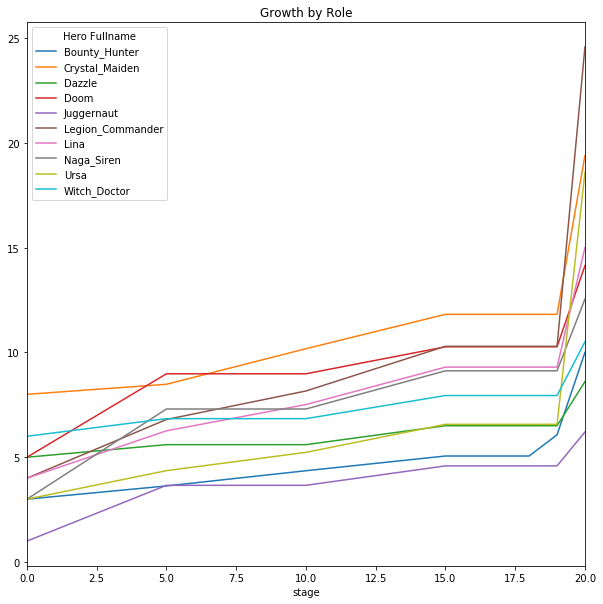

In [153]:
game_impact = combined_plot.groupby(['stage', 'Hero Fullname'])['Level'].sum().unstack().plot(kind='line', figsize=(10,10), title='Growth by Role')
game_impact

radiant_heroes_role
dire_heroes_role

radiant_heroes_lane
dire_heroes_lane